# Poisson Confidence Intervals: Feldman-Cousins
 >__Created__:  21 October 2021 Harrison B. Prosper for LPC Stats 2021<br>
 > __Updated__: May 2022 for INFN School of Statistics

## Introduction
The frequentist principle (Neyman, 1937) requires the following guarantee:

In an infinite ensemble of statements not necessarily about the same thing it is guaranteed that the fraction of true statements, called the __coverage probability__ nevers falls below  the desired __confidence level__.

The standard application of this principle is the construction of confidence intervals $[\, \mu_L(X), \mu_U(X) \,]$ and statements of the form $$\mu \in [\, \mu_L(X), \mu_U(X) \,],$$
where $X$ is a random variable.

## Feldman-Cousins Method
In 1998, Gary Feldman and Robert Cousins$^1$ introduced a method to construct intervals that respect the frequentist principle. This notebook uses this method to illustrate the general procedure for constructing cconfidence intervals using the F-C method as an example.

  1. Gary J. Feldman and Robert D. Cousins, *Unified approach to the classical statistical analysis of small signals*, Phys. Rev. D __57__, 3873, 1998.

In [1]:
# standard system modules
import os, sys

# standard array manipulation module
import numpy as np

# standard scientific python module
import scipy as sp
import scipy.stats as st

# standard symbolic algebra module
import sympy as sm
sm.init_printing()

# standard plotting module
import matplotlib as mp
import matplotlib.pyplot as plt

# arbitrary precision real and complex calculation
#import mpmath

# make plots appear inline
%matplotlib inline

In [2]:
# update fonts
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18
        }
mp.rc('font', **font)
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

### Construct intervals in the space of observations
This notebook applies the Feldman-Cousins method to the Poisson distribution,
$$P(n | \mu) = \frac{e^{-\mu} \mu^n}{n!}.$$
First we choose a confidence level $\textrm{CL} = 1 - \alpha$. For every parameter $\mu$, we choose an interval, $I_\mu$, in the space of observations with probability content CL. Therefore, for a given $\mu$, $1 - \alpha$ is the probability to obtain an observation (here a count) in the interval $I_\mu$. 

We start at $\mu \approx 0$ in the parameter space and at $n_1 = 0$ in the space of observations (which in this example is the set of natural numbers $0\cdots\aleph_0$).
  1. Define an initial interval from $n_1$ to $n_2$, where we choose $n_2 = n_1 + \text{int}(6 \sqrt{\mu})$, whose bounds $n_1$ and $n_2$ may be redefined to create $I_\mu = (n_1, n_2)$.
  1. In the F-C method one computes the ratios $r_n = \text{Poisson}(n, \mu) \, / \,  \text{Poisson}(n, \hat{\mu})$ $ = \mu^n \exp(-\mu) \, / \, n^n \exp(-n)$.
  1. Sort $r_n$ in descending order such that $n_{(1)}$ corresponds to the count with the largest value of $r_n$, $n_{(2)}$ corresponds to the count with the second largest value of $r_n$ and so on.
  1. Compute the sum $p = \text{Poisson}(n_{(1)}, \mu) + \text{Poisson}(n_{(2)}, \mu) + \ldots$ and stop when $p \ge 1 - \alpha$ thereby constructing the set of integers $\{ n_{(i)} \}$.
  1. Label every $n$ in the set $\{ n_{(i)} \}$ with the current value of $\mu$.
  2. Define $I_\mu = (n_1 = \min \{ n_{(i)} \}, n_2 = \max \{ n_{(i)} \})$.
  1. Repeat the above for $\mu \leftarrow \mu + \Delta\mu$.

The above procedure builds a set of horizontal dots (because $n$ is discrete) in the space of observations, one for each value of $\mu$ and thereby, for every $n$, builds the interval $[l(n)$ and $u(n)]$ in the space of the parameter $\mu$. For a given $n$, $[l(n)$ and $u(n)]$ is the *confidence interval* associated with $n$.

In [3]:
CL    = 0.683  # desired confidence level
MUMIN =  0
MUMAX = 25
MUSTEP= 0.01

In [4]:
def compute_obs_interval(mu, n1, cache, cl):
    
    # step 1: define range to scan in space of observations for I_mu
    n2 = n1 + int(6*np.sqrt(mu))
    
    # step 2: compute ratios
    rn = []
    for n in range(n1, n2+1) :
        p = st.poisson.pmf(n, mu)
        q = st.poisson.pmf(n, n)
        rn.append((p / q, p, n))

    # steo 3: sort in descending order
    rn.sort()
    rn.reverse()

    # step 4: label every n within interval with associated mu
    m = []
    p = 0.0 # probability content of interval
    for _, pn, n in rn:
        if n not in cache:
            cache[n] = []
        cache[n].append(mu)
        m.append(n)
        p += pn
        if p >= cl:
            break
            
    # step 5: determine interval I(mu) = [n1, n2]
    m.sort()
    m  = np.array(m)
    n1 = m.min()
    n2 = m.max()

    # check that counts are contiguous
    # u =  n1 + ... + n2 + n2 + ... + n1
    # u = len(m)*(n1+n2)
    u = (np.arange(n1,n2+1) + np.arange(n2,n1-1,-1)).sum()
    w = len(m) * (n1 + n2)
    if u != w:
        print('** non-contiguous interval: %s\tmu = %5.2f' % (m, mu))

    return (p, n1, n2)

### Confidence Intervals
Every count $n$ is associated with a range of values of $\mu$ called a __confidence interval__, or more generally a confidence set. Find the  lower and upper bound of the $\mu$ values for each $n$.

In [13]:
def compute_intervals(cl, 
                      mumin=MUMIN, mumax=MUMAX, mustep=MUSTEP):
    # mumin:  minimum mean value
    # mumax:  maximum mean value
    # mustep: step in mean value

    # number of points in mu at which to construct an interval in
    # the space of counts.
    N = int(1.5*(mumax-mumin)/mustep)

    # cache the value of mu associated with each count.
    # the lower and upper limits of the confidence interval
    # associated with a count are just the minimum and
    # maximum values of mu for a given count.
    cache = {}

    mu = [] # mu values
    p  = [] # coverage probability
    n1 = 0  # lower bound of interval in space of observations

    obs_int = []
    for i in range(N):
        x = (i+1) * mustep
        q, n1, n2 = compute_obs_interval(x, n1, cache, cl)
    
        # accumulate coverage vs. mu
        if x <= mumax:
            if i % 5 == 0:
                mu.append(x)
                p.append(q)

        if i % 250 == 0:
            print('%10.1f %10.3f %5d %5d' % (x, q, n1, n2))
            obs_int.append((x, n1, n2))
            
    # get confidence intervals
    intervals = []
    for n in range(mumax+1):
        lower = min(cache[n])
        upper = max(cache[n])
        intervals.append((lower, upper))
    return (intervals, mu, p, obs_int)

In [14]:
intervals, mu, p, obs_int = compute_intervals(CL)

       0.0      0.990     0     0
       2.5      0.809     1     4
       5.0      0.742     3     7
       7.5      0.730     5    10
      10.0      0.734     7    13
      12.5      0.744     9    16
      15.0      0.691    12    19
      17.5      0.712    14    22
      20.0      0.687    16    24
      22.5      0.709    18    27
      25.0      0.730    20    30
      27.5      0.702    23    33
      30.0      0.685    25    35
      32.5      0.708    27    38
      35.0      0.686    30    41


### Plot coverage vs. mean count $\mu$

In [7]:
def plot_coverage(x, y, cl,
                  xmin=MUMIN, xmax=MUMAX, 
                  ymin=0, ymax=1, 
                  ftsize=20, 
                  fgsize=(6, 5)):
   
    # set size of figure
    plt.figure(figsize=fgsize)
    
    # plot points 
    plt.plot(x, y, color='steelblue', 
             label='Feldman-Cousins intervals')
    
    percent = '%s' % '%'
    icl = int(100*cl)
    plt.plot([xmin, xmax], [cl, cl], 
             color='magenta',linestyle='--', 
             label='CL = %5.3f' % cl)

    # add legends 
    plt.legend(fontsize=18)
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
   
    # add x and y labels
    plt.xlabel(r'$\mu$', fontsize=ftsize)
    plt.ylabel(r'Pr[$\,\mu \in (\mu_L, \, \mu_U)\,$]', 
               fontsize=ftsize)
 
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    
    filename = "fig_poisson_FC_coverage_%2.2d.pdf" % icl
    print(filename)
    plt.savefig(filename)
    plt.show()

fig_poisson_FC_coverage_68.pdf


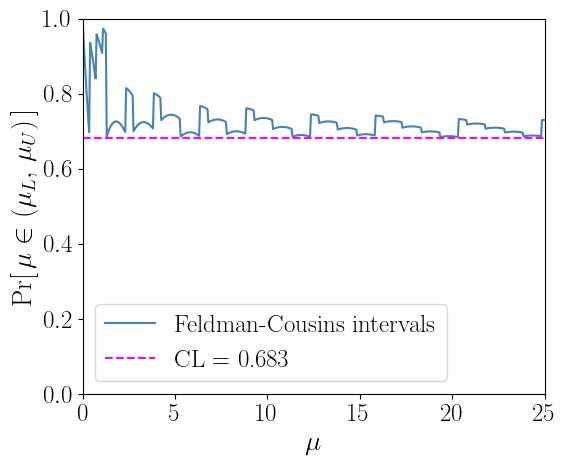

In [8]:
plot_coverage(mu, p, CL)

In [15]:
def plot_intervals(intervals, obs, cl, 
                   xmin=MUMIN, xmax=MUMAX, 
                   ymin=0, ymax=MUMAX, 
                   ftsize=20, 
                   fgsize=(6, 5)):

    # set size of figure
    plt.figure(figsize=fgsize)
    
    # plot points
    for n, y in enumerate(intervals[:-1]):
        x = (n, n)
        if n < 10:
            print('%5d %5.2f, %5.2f' % (n, y[0], y[1]))
        plt.plot(x, y, color='steelblue', linewidth=2)
    n = len(intervals)
    x = (n, n)
    y = intervals[-1]
    plt.plot(x, y, color='steelblue', linewidth=2, 
             label='%5.3f CL F-C intervals' % cl)
    
    # add legends 
    plt.legend()
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
   
    # add x and y labels
    plt.xlabel(r'$N$', fontsize=ftsize)
    plt.ylabel(r'$[\,\mu_L(N), \, \mu_U(N)\,]$', 
               fontsize=ftsize)
    X = []
    Y = []
    for mu, n1, n2 in obs:
        for n in range(n1, n2+1):
            X.append(n)
            Y.append(mu)
    plt.scatter(X, Y, color='red')
    
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    
    icl = int(100*cl)
    filename = "fig_poisson_FC_intervals_%d.pdf" % icl
    print(filename)
    plt.savefig(filename)
    plt.show()

    0  0.01,  1.29
    1  0.37,  2.75
    2  0.74,  4.25
    3  1.11,  5.30
    4  2.34,  6.77
    5  2.76,  7.80
    6  3.83,  9.27
    7  4.26, 10.30
    8  5.31, 11.31
    9  6.34, 12.79
fig_poisson_FC_intervals_68.pdf


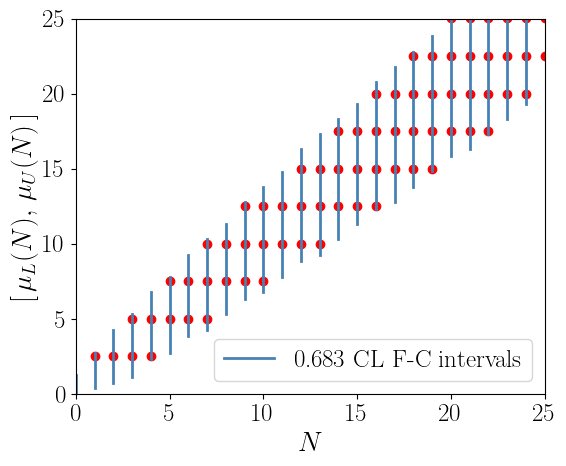

In [16]:
plot_intervals(intervals, obs_int[1:], CL)